In [1]:
import warnings
import datetime
import numpy as np
import pandas as pd
import pickle as pkl
from seaborn import plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import TimeSeriesSplit
%matplotlib inline

# 1. Preliminary steps
## 1.1 Load glucose data

In [2]:
# load data set from pickle file
dfs_full = pkl.load(open('../dfs_py3.pkl', 'rb'))

## 1.1 Define utility functions

In [3]:
def gluco_extract(df, return_df=False):
    """Extract glucose trend and time axis of a given patient.
    
    Parameters
    -------------------
    df : pandas DataFrame, tabular info coming from Medtronic Diabetes iPro
         Data Export File (v1.0.1) (see data_wrangler.py)
    return_df : bool, when this flag is set to true, the function returns a single
                pandas DataFrame containing the glucose level indexed by times
    
    Returns
    -------------------
    time : array of datetimes, the glucose measuring time span (if return_df=False)
    gluco : array of float, the correspondent glucose level (if return_df=False)
    df_tg : pandas.DataFrame, gluco indexed by times (if return_df=True)
    """
    # Select glucose, time and date
    column = 'Sensor Glucose (mg/dL)'
    _gluco = df[column]
    _time = df['Time']
    _date = df['Date']
    
    # Create a new data frame and drop missing values
    _df = pd.concat((_gluco, _time, _date), axis=1).dropna()
    
    # Parse time axis
    time = []
    for (d, h) in zip(_df['Date'], _df['Time']):
        _d = datetime.datetime.strptime(d,'%d/%m/%y').date()
        _h = datetime.datetime.strptime(h,'%H:%M:%S').time()
        time.append(datetime.datetime.combine(_d, _h))
    
    # Extract glucose level
    gluco = _df[column]
    
    if return_df:
        return pd.DataFrame(data=gluco.values, index=pd.DatetimeIndex(time), columns=[column])
    else:
        return time, gluco

    
def gluco_plot(time, gluco, hypo=70, hyper=126, title="Patiend ID glucose level"):
    """Plot the glucose level on a time span.
    
    Parameters
    -------------------
    time : array of datetimes, the horizontal axis
    gluco : array of float, the correspondent glucose level on the vertical axis
    hypo : number, hypoglicaemia threshold in mg/dl (default is 70, i.e. 3.9 mmol/l)
    hyper : number, hyperglicaemia threshold in mg/dl (default is 126, i.e. 7 mmol/l)
    title : string, the title of the plot (optional)
    """
    plt.figure(figsize=(10,6))
    plt.hlines(hypo, time[0], time[-1], linestyles='dashed', label='hypoglicaemia')
    plt.hlines(hyper, time[0], time[-1], linestyles='dotted', label='hyperglicaemia')
    plt.ylim([10, 410])
    plt.plot_date(time, gluco, '-', label='glucose level')
    plt.title(title)
    plt.ylabel('mg/dL')
    plt.xticks(rotation='vertical')
    plt.legend();
    
def autocorr_plot(ts, lags=None):
    """Plot the (partial) autocorrelation of a given time-series.
    
    Parameters
    -------------------
    ts : array of float, time-series values
    lags : array of int, lag values on horizontal axis.
    """
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(ts, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(ts, lags=lags, ax=ax2)
    plt.suptitle('Lags: {}'.format(lags))

## 1.1 Remove short acquisitions

In [4]:
# Keep only patients with more than 3.5 days of acquisition
thresh = datetime.timedelta(days=3.5)

# List of patients that satisfy inclusion criterion
ok_keys = []

for k in dfs_full.keys():
    df = dfs_full[k]
    time, gluco = gluco_extract(df)
    try:
        delta = time[-1] - time[0]
        if delta > thresh: ok_keys.append(k)
    except:
        pass
# Filter short time-series
dfs = {k: dfs_full[k] for k in ok_keys}

Orbassano, Elisa Francesca.csv


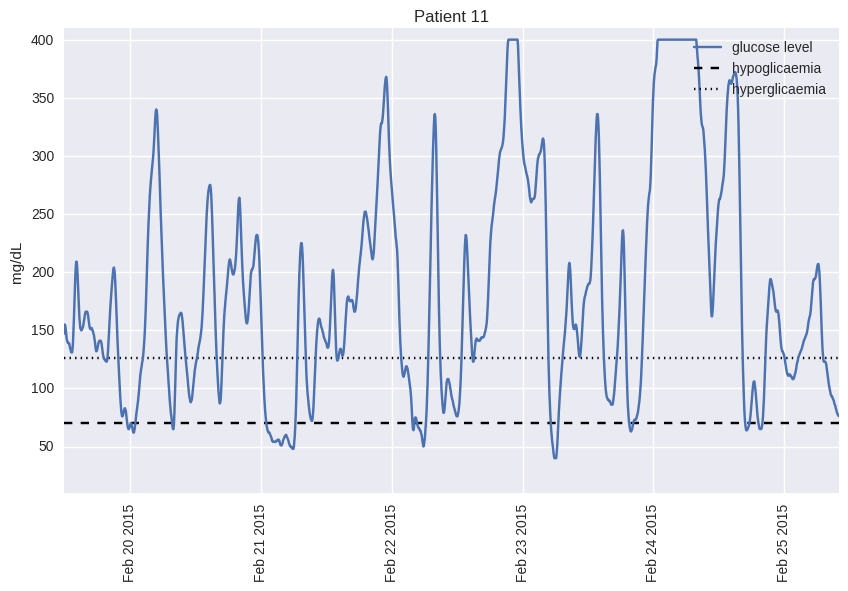

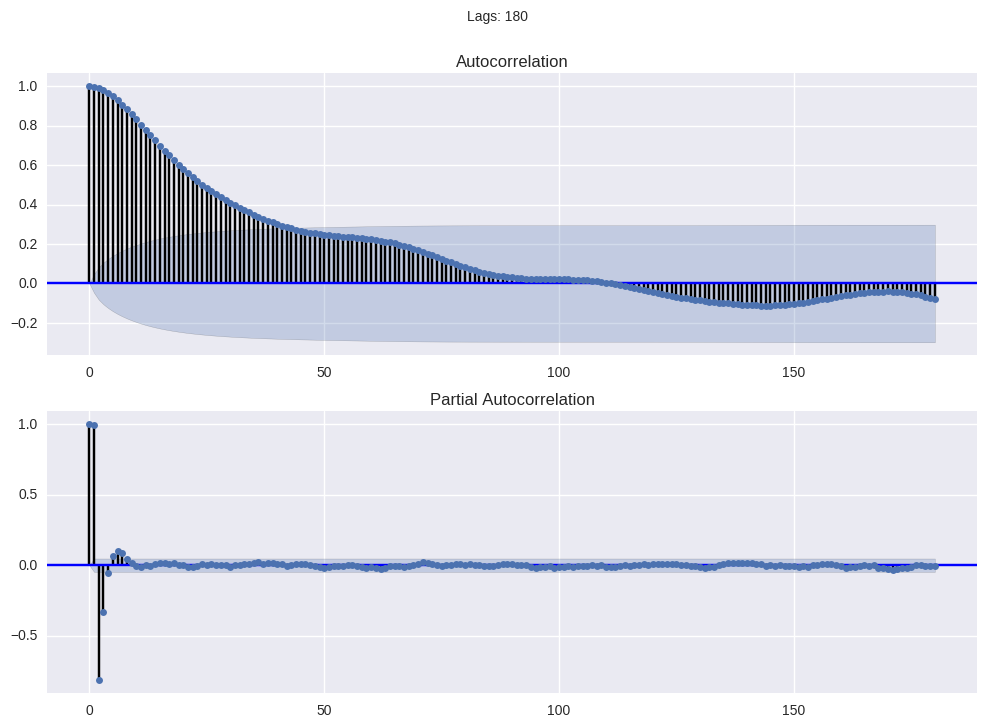

In [5]:
# Example: plot the k-th patient
k = 11
idx = list(dfs.keys())[k]
print(idx)

# Select the appropriate DF
df = dfs[idx]
   
time, gluco = gluco_extract(df)
gluco_plot(time, gluco, title='Patient '+str(k))

# Plot the (partial) autocorrelation
autocorr_plot(gluco, lags=180)

# 2. Run predictions
## 2.1 ARIMA

In [6]:
warnings.filterwarnings('ignore')

In [16]:
def moving_window_ARIMA(df, w_size=30, ph=18, p=2, d=1, q=1,
                        start_params=None, open_loop=False, verbose=False):
    """Fit a moving-window ARMA model with fixed window size.
    
    This function tries to fit a moving-window AIRMA model on input time-series.
    In case of failure, due to numpy.linalg.linalg.LinAlgError, the function returnn np.nan.
    
    Parameters
    -------------------
    df : DataFrame, the output returned by gluco_extract(..., return_df=True)
    w_size : number, the window size (default=30, i.e. 150 mins (2.5 hours))
    ph : number, the prediction horizon. It must be w_size > ph (default=18, i.e. 90 mins (1.5 hours))
    p : number, AR order (default=2)
    d : number, I order (default=1)
    q : numnber, MA order (default=1)
    start_params : array of length p + q, the starting parameters for the ARIMA model (default=None)
    verbose : bool, print debug messages each 100 iterations (default=False)
    
    Returns
    -------------------
    errs : dictionary, errors at 30/60/90 mins ('err_18', 'err_12', 'err_6':)
    open_loop : bool, when True the size of the forecast is n_samples - w_size - ph,
                else 
    forecast : dictionary, time-series prediction ['ts'], with std_dev ['sigma']
               and confidence interval ['conf_int'].
    """
    # Argument check
    if w_size < ph:        
        raise NotImplementedError('The length of the window size %d should be '
                                  'larger than the prediction horizon %d' % (w_size, ph))
    n_samples = df.shape[0]

    # Absolute prediction error at 30/60/90 minutes
    errs = {'err_18': [], 'err_12': [], 'err_6': []}
    forecast = {'ts': [], 'sigma': [], 'conf_int': []} # 1 step-ahead predictions

    # Move the window across the signal
    for w_start in range(n_samples - (w_size + ph)):
        w_end = w_start + w_size
        y = df.iloc[w_start:w_end] # beware: y is a time-indexed pandas DataFrame

        # Fit the model and forecast the next ph steps
        try:
            model = sm.tsa.ARIMA(y, (p, d, q)).fit(trend='nc',
                                                   start_params=start_params,
                                                   solver='cg', maxiter=500, disp=0)
            y_pred, std_err, conf_int = model.forecast(ph)
            
        except np.linalg.linalg.LinAlgError as e:
            print("CRITICAL: {}".format(e))
            return np.nan, np.nan
        
        # Check if the real acquisistions are over
        if (w_end + ph) < n_samples:
            
            # Save the 1-step ahead prediction (for plotting reasons)
            forecast['ts'].append(y_pred[0])
            forecast['sigma'].append(std_err[0])
            forecast['conf_int'].append(conf_int[0])
            
            # Evaluate the errors
            y_future_real = df.iloc[w_end:w_end + ph].values.ravel()
            abs_pred_err = np.abs(y_pred - y_future_real)
            
            # Save errors
            errs['err_18'].append(abs_pred_err[17])
            errs['err_12'].append(abs_pred_err[11])
            errs['err_6'].append(abs_pred_err[5])
            
            if (w_start % 200) == 0 and verbose:
                print("[:{}]\nErrors: 30' = {:2.3f}\t|\t60' = "
                      "{:2.3f}\t|\t90' = {:2.3f}".format(w_end, errs['err_6'][-1],
                                                         errs['err_12'][-1],
                                                         errs['err_18'][-1]))
                print(model.params)

        else:
            print('cane!!!!!!!!!!!!')
            if open_loop:
                # Save the last (open-loop) predictions
                forecast['ts'].extend(y_pred.tolist())
                forecast['sigma'].append(std_err)
                forecast['conf_int'].append(conf_int)
            else: break   

        # Update the starting parameters (warm restart)
        start_params = model.params.copy()
    
    # Return numpy.array
    forecast['ts'] = np.array(forecast['ts'])
    forecast['sigma'] = np.array(forecast['sigma'])
        
    return errs, forecast

In [ ]:
# select patient
idx = list(dfs.keys())[10]
df = gluco_extract(dfs[idx], return_df=True)

df = df.iloc[:1000]

p, d, q = 2, 1, 1

# Window-size and prediction horizon
w_size = 30
ph = 18

# perform moving-window arma
errs, forecast = moving_window_ARIMA(df, w_size=w_size, ph=ph,
                                     p=p, d=d, q=q,
                                     start_params=None, verbose=True)

In [17]:
print(len(forecast['ts']))

952


In [20]:
1000 - 30 - 18

952

In [10]:
def grid_search_ARIMA(df, burn_in=300, n_splits=15, p_bounds=(2, 8), d_bounds=(1, 2),
                      q_bounds=(2, 4), ic_score='AIC', return_final_index=False, verbose=False):
    """Find the best ARIMA parameters via grid search cross-validation.
    
    This function perform a grid search of the optimal (p, d, q)
    parameters of the ARIMAsklearn.model_selection.TimeSeriesSplit
    on input data. The index to optimize can be either AIC or BIC.
    
    Parameters
    -------------------
    df : DataFrame, the output returned by gluco_extract(..., return_df=True)
    burn_in : number, the number of samples at the beginning of the time-series that
              should be splitted to perform grid search (default = 300)
    n_splits : number, the number of splits of the time-series cross-validation schema (default=15).
               Your prediction horizon will be `floor(n_samples / (n_splits + 1))`
    p_bounds : tuple, the AR parameters range organized as (min_p, max_p) (default = (4, 8))
    d_bounds : tuple, the I parameters range organized as (min_d, max_d) (default = (1, 2))
    q_bounds : tuple, the MA parameters range organized as (min_q, max_q) (default = (2, 4))
    ic_score : str, this can be either 'AIC' (default) or 'BIC'
    return_final_index : bool, return the final index as second argument (default=False)
    verbose : bool, print debug messages (default=False)
    
    Returns
    -------------------
    optimal_order : tuple, the obtained optimal order (p, d, q) for the ARIMA model
    final_index : array_like, the index obtained by the sum of the cross-validation
                  out-of-samples (validation) prediction with the chosed information
                  criteria
    """
    n_samples = df.shape[0]
    
    # Argument check
    if n_samples < burn_in:
        raise Exception('The number of burn in samples %d should be '
                        'smaller than the total number of samples %d' % (burn_in, n_samples))
    if ic_score not in ['AIC', 'BIC']:
        warnings.warn('Information criterion %s not understood, using default.' % ic_score)
        ic_score = 'AIC'
    
    # Isolate the burn in samples
    time_series = df.iloc[:burn_in]
       
    # Get the parameter bounds & ranges
    min_p, max_p = p_bounds
    min_d, max_d = d_bounds
    min_q, max_q = q_bounds
    p_range = np.arange(min_p, max_p + 1)
    d_range = np.arange(min_d, max_d + 1)
    q_range = np.arange(min_q, max_q + 1)
    
    # Parameter grid definition
    param_grid = ParameterGrid({'p': p_range, # AR order
                                'd': d_range, # I order
                                'q': q_range}) # MA order

    # Time-series cross validation split
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Initialize the cross-validation error tensor of size (len(p_range), len(d_range), len(q_range))
    mean_vld_error = np.zeros((len(p_range), len(d_range), len(q_range)))
    std_vld_error = np.zeros_like(mean_vld_error)
    
    # Initialize the information criteria tensor of size (len(p_range), len(d_range), len(q_range))
    mean_ic_score = np.zeros_like(mean_vld_error)
    std_ic_score = np.zeros_like(mean_ic_score)

    # Iterate trough the model parameters (p, d, q)
    for param in param_grid:
        if verbose: print('trying params {} ...'.format(param))
        p, d, q = param['p'], param['d'], param['q']
        order = (p, d, q)
        start_params = None # use warm restart
        
        # i, j, k index will be used to access the mean_vld_error tensor
        i, j, k = p - min_p, d - min_d, q - min_q
    
        # Init the vld_error vector for the current order
        vld_error = np.zeros(n_splits)
        ic_score = np.zeros_like(vld_error)
        
        # Iterate through the CV splits
        for cv_count, (tr_index, vld_index) in enumerate(tscv.split(time_series)):
            try:
                y_tr, y_vld = time_series.iloc[tr_index], time_series.iloc[vld_index]        

                # Fit the model on the training set and forecast the validation set
                model = sm.tsa.ARIMA(y_tr, order).fit(trend='nc',
                                                      start_params=start_params,
                                                      solver='cg', maxiter=500, disp=0)
                y_pred, _, _ = model.forecast(len(y_vld))
                start_params = model.params.copy() # warm restart
            
                # Save the current vld error (in terms of mean squared error)
                _current_vld_err = mean_squared_error(y_pred, y_vld)
                
                # Save the specified information criteria
                _current_ic_score = model.aic if ic_score == 'AIC' else model.bic
            except Exception as e:
                if verbose: warnings.warn('statsmodels.tsa.arima_model.ARIMA raised:\n%s' % e)
                _current_vld_err = np.nan
                _current_ic_score = np.nan
            
            # Save vld error and ic score
            vld_error[cv_count] = _current_vld_err
            ic_score[cv_count] = _current_ic_score
        
        # Save mean and standard deviation of cross-validation error (excluding NaNs)
        mean_vld_error[i, j, k] = np.nanmean(vld_error)
        std_vld_error[i, j, k] = np.nanstd(vld_error)
        
        # Save mean and standard deviation of cross-validation information criteria (excluding NaNs)
        mean_ic_score[i, j, k] = np.nanmean(ic_score)
        std_ic_score[i, j, k] = np.nanstd(ic_score)
        
    # Get the optimal orders from the score that we want to optimize
    final_index = mean_ic_score + mean_vld_error
    _ip, _id, _iq = np.where(final_index == np.nanmin(final_index))
    
    # Re-convert the indexes of the tensor in one of the input ARIMA order
    p_opt = _ip[0] + min_p
    d_opt = _id[0] + min_d
    q_opt = _iq[0] + min_q
    
    if return_final_index:
        return (p_opt, d_opt, q_opt), final_index
    else:
        return (p_opt, d_opt, q_opt)

In [13]:
# select patient
idx = list(dfs.keys())[100]
df = gluco_extract(dfs[idx], return_df=True)

# learn the best order
# opt_order, final_index = grid_search_ARIMA(df, burn_in=144, n_splits=8, p_bounds=(1, 4), d_bounds=(1, 2),
#                                            q_bounds=(1, 4), ic_score='AIC', return_final_index=True, verbose=True)
# opt_order, final_index = grid_search_ARIMA(df, burn_in=300, n_splits=15, p_bounds=(1, 4), d_bounds=(1, 2),
#                                            q_bounds=(1, 4), ic_score='AIC', return_final_index=True, verbose=True)

opt_order = (2, 2, 1)

print(opt_order)
p, d, q = opt_order

# Window-size and prediction horizon
w_size = 30
ph = 18

# perform moving-window arma
errs, forecast = moving_window_ARIMA(df, w_size=w_size, ph=ph,
                                     p=p, d=d, q=q,
                                     start_params=None, verbose=True)

(2, 2, 1)
[:30]
Errors: 30' = 28.605	|	60' = 111.655	|	90' = 247.873
ar.L1.D2.Sensor Glucose (mg/dL)    0.044899
ar.L2.D2.Sensor Glucose (mg/dL)    0.684722
ma.L1.D2.Sensor Glucose (mg/dL)    0.293481
dtype: float64
[:230]
Errors: 30' = 25.000	|	60' = 15.000	|	90' = 68.000
ar.L1.D2.Sensor Glucose (mg/dL)    1.526398
ar.L2.D2.Sensor Glucose (mg/dL)   -0.526399
ma.L1.D2.Sensor Glucose (mg/dL)   -1.000000
dtype: float64
[:430]
Errors: 30' = 32.000	|	60' = 12.000	|	90' = 35.000
ar.L1.D2.Sensor Glucose (mg/dL)    1.49112
ar.L2.D2.Sensor Glucose (mg/dL)   -0.49112
ma.L1.D2.Sensor Glucose (mg/dL)   -1.00000
dtype: float64
[:630]
Errors: 30' = 14.000	|	60' = 12.000	|	90' = 23.001
ar.L1.D2.Sensor Glucose (mg/dL)    1.406448
ar.L2.D2.Sensor Glucose (mg/dL)   -0.406448
ma.L1.D2.Sensor Glucose (mg/dL)   -1.000000
dtype: float64
[:830]
Errors: 30' = 3.234	|	60' = 5.251	|	90' = 3.265
ar.L1.D2.Sensor Glucose (mg/dL)    0.497391
ar.L2.D2.Sensor Glucose (mg/dL)    0.502609
ma.L1.D2.Sensor Glucose (mg/d

KeyboardInterrupt: 

In [ ]:
# plot results
gluco_plot(df.index[w_size:-ph], df.as_matrix()[w_size:-ph], title='Patient '+str(k))
plt.plot(df.index[w_size:-ph], forecast['ts'], linestyle='dashed', label='forecast')
plt.legend(bbox_to_anchor=(1.2, 1.0))
MAE_6 = np.mean(errs['err_6'])
MAE_12 = np.mean(errs['err_12'])
MAE_18 = np.mean(errs['err_18'])
RMSE_6 = np.linalg.norm(errs['err_6']) / np.sqrt(len(errs['err_6']))
RMSE_12 = np.linalg.norm(errs['err_12']) / np.sqrt(len(errs['err_12']))
RMSE_18 = np.linalg.norm(errs['err_18']) / np.sqrt(len(errs['err_18']))
print("MAE (30') = {:2.3f}\t|\tMAE (60') = {:2.3f}\t|\tMAE (90') = {:2.3f}".format(MAE_6, MAE_12, MAE_18))
print("RMSE (30') = {:2.3f}\t|\tRMSE (60') = {:2.3f}\t|\tRMSE (90') = {:2.3f}".format(RMSE_6, RMSE_12, RMSE_18))

In [ ]:
residuals = df.as_matrix()[w_size:-ph].ravel() - forecast['ts']
fig = plt.figure(figsize=(12, 4))
plt.plot(df.index[w_size:-ph], residuals)
plt.title('Durbin-Watson: {:.3f}'.format(sm.stats.durbin_watson(residuals)));